In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ellc
from ellc import lc

# import edmcmc as edm
# import batman

In [ ]:
start_time = 0  # start at t = 0 (in arbitrary units, such as days)
transit_time= 2/24 #expected transit time in days, transit duration approx 2 hours
pre_post= (2+2)/24 #pre and post transit observation hours to days 
duration = (transit_time+pre_post)  # TOTAL observing sequence in days

exp_time = 15 / 60 / 24  # 15 minutes in days, aka approx exposure time
time = np.arange(start_time, start_time + duration, exp_time) #in days

#unit of time can be anything as long as it is consistent throughout
period = 3.74 #days

t_zero = start_time + (duration / 2) #0.5*period #days, Time (or phase) of mid-eclipse for star 1 by planet.
# print(t_zero)
a=0.04666*215.032 #semi-major axis au to solar radii for calculation of light travel time and Doppler boosting.

sbratio = 0# 1192/5377 #Surface brightness ratio, S_2/S_1 or T2/T1
r_1 = 1.36/a #Radius of star 1 in units of the semi-major axis of the binary
r_2 = (13.125739/109)/a #Radius of planet in Rsun then to sma units
incl = 85.68 #inclination in deg
q = (211.99261/333000)/0.93 #Mass ratio m_2/m_1,both in Msun

#Limb darkening law
ld_1 = 'quad' #{None, "lin", "quad", "sing", "claret", "log", "sqrt", "exp","power-2", "mugrid"}
ldc_1 = [0.34,0.26] #Limb darkening coefficients for star, from q1 TESS
# ld_2 = 'quad'
# ldc_2 = [0.46, 0.567] #Limb darkening coefficients for planet

shape = 'sphere'
# heat = [0.6,3.5,0.0] #could also just do simplified model (see help)

vsini_1=1.5 #V_rot.sini for calculation of R-M effect for star 1 [km/s]
vsini_2=0  #for planet

ecc=0.024 #eccentricity
w=90.0 #39 #longitude of periastron
f_c = np.sqrt(ecc)*np.cos(np.radians(w))
f_s = np.sqrt(ecc)*np.sin(np.radians(w))

obliq=0 #obliquity angle in degrees

In [50]:
# Generate the light curve
flux = lc(
    t_obs=time,
    radius_1=r_1,
    radius_2=r_2,
    sbratio=sbratio,
    incl=incl, lambda_1=0,
    t_zero=t_zero,
    period=period,
    q=q, a=a,
    f_c=f_c,
    f_s=f_s,
    vsini_1=vsini_1, vsini_2=vsini_2,
    ldc_1=ldc_1,   #Use ldc_1 for limb darkening coefficients
    ld_1="quad",
    shape_1=shape,  # Assume spherical shape for the star
    shape_2=shape,  # Assume spherical shape for the planet
    verbose=False)


#RV curve "data"=model+noise
star_rv,planet_rv = ellc.rv(time,t_zero=t_zero, q=q,vsini_1=vsini_1,vsini_2=vsini_2,
    radius_1=r_1, radius_2=r_2,incl=incl, lambda_1=obliq, sbratio=sbratio,  
    ld_1=ld_1, ldc_1=ldc_1, a=a, f_c=f_c, f_s=f_s,
    period=period, shape_1=shape,shape_2=shape,flux_weighted=True) # heat_2 = heat


# Add Gaussian noise
sigma= 0.001
mean_noise = 0.0           # Mean of the noise
std_dev_noise = sigma      # Standard deviation of the noise (in km/s)
noise = np.random.normal(mean_noise, std_dev_noise, len(star_rv))
rv_noisy = np.copy(star_rv) + noise

In [ ]:
#RV curve model
time_sim = np.arange(min(time), max(time), exp_time/1000)


star_rv_sim ,planet_rv_sim = ellc.rv(time_sim,t_zero=t_zero, q=q,vsini_1=vsini_1,vsini_2=vsini_2,
    radius_1=r_1, radius_2=r_2,incl=incl, lambda_1=obliq, sbratio=sbratio,  
    ld_1=ld_1, ldc_1=ldc_1, a=a, f_c=f_c, f_s=f_s,
    period=period, shape_1=shape,shape_2=shape,flux_weighted=True) 

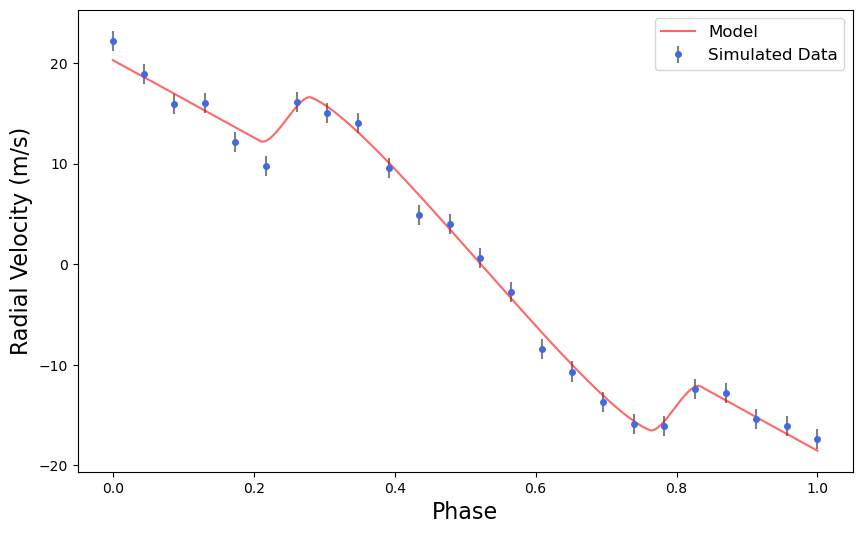

In [80]:
plt.figure(figsize=(10, 6))
plt.errorbar(time/time[-1],np.array(rv_noisy)*1e3, yerr=std_dev_noise*1e3,ms=8, fmt='.',c='royalblue', ecolor='gray', capsize=0, label='Simulated Data')
plt.plot(time_sim/time_sim[-1],star_rv_sim*1e3,'r-',ms=2.2,alpha=0.6,label='Model')
# plt.plot(time/time[-1],star_rv*1e3,'.',c='green', label='True RV without noise') #this should match the model line


plt.xlabel('Phase', fontsize=16)
plt.ylabel('Radial Velocity (m/s)', fontsize=16)
# plt.grid()
plt.legend(fontsize=12)
plt.show()


Text(0, 0.5, 'Normalized Flux')

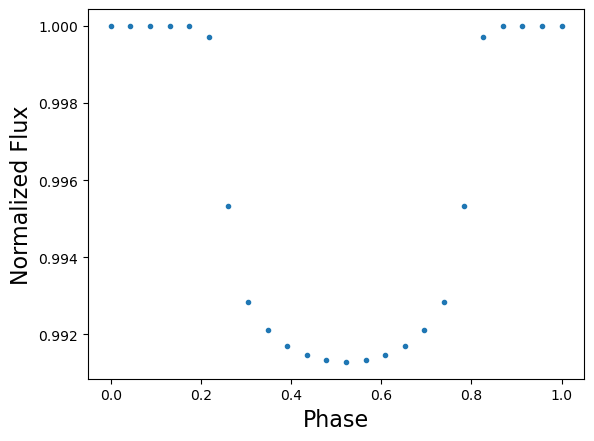

In [79]:
plt.plot(time/time[-1],flux,'.')

plt.xlabel('Phase', fontsize=16)
plt.ylabel('Normalized Flux', fontsize=16)

In [82]:
#there's also this function to phase fold more mathematically accurate
def maketmodn(t, p, e): #from Andrew, for phase-folding
    '''t= time array, p= period, e= epoch (aka time at mid-transit)'''
    tmodn = (t % p) - (e % p)
    tmodn = tmodn + p * np.array((tmodn < -0.5 * p), dtype=float) - p * np.array((tmodn >= 0.5 * p), dtype=float)
    return tmodn

Text(0, 0.5, 'Radial Velocity (m/s)')

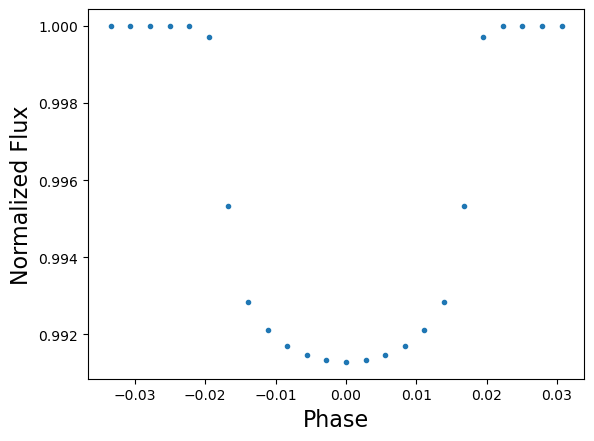

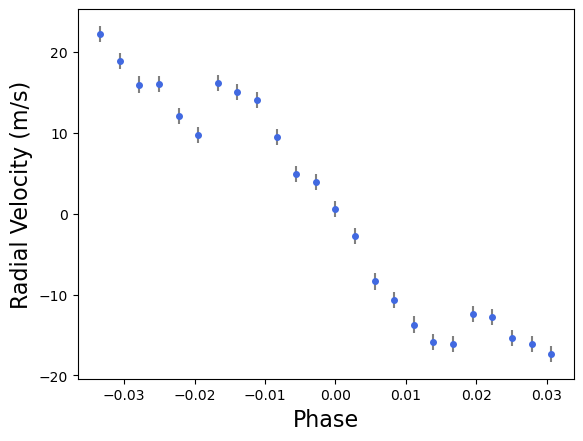

In [85]:
plt.figure()
plt.plot(maketmodn(time,period,t_zero)/period,flux,'.')
plt.xlabel('Phase', fontsize=16)
plt.ylabel('Normalized Flux', fontsize=16)

plt.figure()
plt.errorbar(maketmodn(time,period,t_zero)/period,np.array(rv_noisy)*1e3, yerr=std_dev_noise*1e3,ms=8, fmt='.',c='royalblue', ecolor='gray', capsize=0, label='Simulated Data')
plt.xlabel('Phase', fontsize=16)
plt.ylabel('Radial Velocity (m/s)', fontsize=16)